In [ ]:
!pip install dm-haiku sacred
!git clone https://github.com/edmundlth/validating_lambdahat.git
!cd validating_lambdahat && git checkout dev
import sys
sys.path.append("./validating_lambdahat/")

In [1]:
import haiku as hk
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
from typing import Sequence, NamedTuple
import json

import matplotlib.pyplot as plt

from expt_dln import ex

In [44]:

config = {
    "expt_name": "hyperparam_tuning_run",
    "do_compute_distance": False,
    "do_functional_rank": False,
    "do_hessian_trace": False,
    "do_training": False,
    "input_dist": "uniform",
    "input_dim": np.random.randint(50, 500),
    "layer_widths": np.random.randint(50, 500, size=6),
    "num_training_data": 50000,
    "seed": np.random.randint(1, 1000),
    "sgld_config": {
        "batch_size": 500,
        "epsilon": 2e-7,
        "gamma": 1.0,
        "num_chains": 1,
        "num_steps": 30000
    },
    "true_param_config": {
        "mean": 0.0,
        "method": "rand_rank",
        "prop_rank_reduce": 0.5,
        "std": 5.0
    },
    "verbose": True, 
}
print(config["layer_widths"], f"num layer={len(config['layer_widths'])}")
run = ex.run(config_updates=config)

WARNING - root - Changed type of config entry "layer_widths" from list to ndarray
WARNING - dln_lambdahat - No observers have been added to this run
INFO - dln_lambdahat - Running command 'run_experiment'
INFO - dln_lambdahat - Started


[395 125 350 277 261 297] num layer=6
Step 0, loss: 0.0012086154893040657
Step 200, loss: 0.22350925207138062
Step 400, loss: 0.4094361960887909
Step 600, loss: 0.5565894246101379
Step 800, loss: 0.7142777442932129
Step 1000, loss: 0.8427528142929077
Step 1200, loss: 0.9593626856803894
Step 1400, loss: 1.0519847869873047
Step 1600, loss: 1.159236192703247
Step 1800, loss: 1.2496575117111206
Step 2000, loss: 1.3630237579345703
Step 2200, loss: 1.4481159448623657
Step 2400, loss: 1.5155144929885864
Step 2600, loss: 1.5907506942749023
Step 2800, loss: 1.6423943042755127
Step 3000, loss: 1.6683531999588013
Step 3200, loss: 1.7591866254806519
Step 3400, loss: 1.8510178327560425
Step 3600, loss: 1.9114329814910889
Step 3800, loss: 1.923115849494934
Step 4000, loss: 1.991583228111267
Step 4200, loss: 2.0432863235473633
Step 4400, loss: 2.093625783920288
Step 4600, loss: 2.128570556640625
Step 4800, loss: 2.1857876777648926
Step 5000, loss: 2.1974949836730957
Step 5200, loss: 2.271624326705932

/Users/edmund/.local/share/virtualenvs/validating_lambdahat-UCObfUVw/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3961: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


M_list: [427 367  97 322 249 233 269], indices: [2 5 4 6], M_subset: [ 97 233 249 269]


INFO - dln_lambdahat - Completed after 0:08:23


lambdahat                : 13450.8779296875
lambdahat_with_burnin    : 16304.276972105034
true_lambda              : 20546.5078125
true_multiplicity        : 3.0
true_rank                : 28
model_dim                : 519614
num_layers               : 6
mean_mala_acceptance_prob: 0.9975112471580505
layer_widths             : [395 125 350 277 261 297]
num_training_data        : 50000
input_dim                : 455


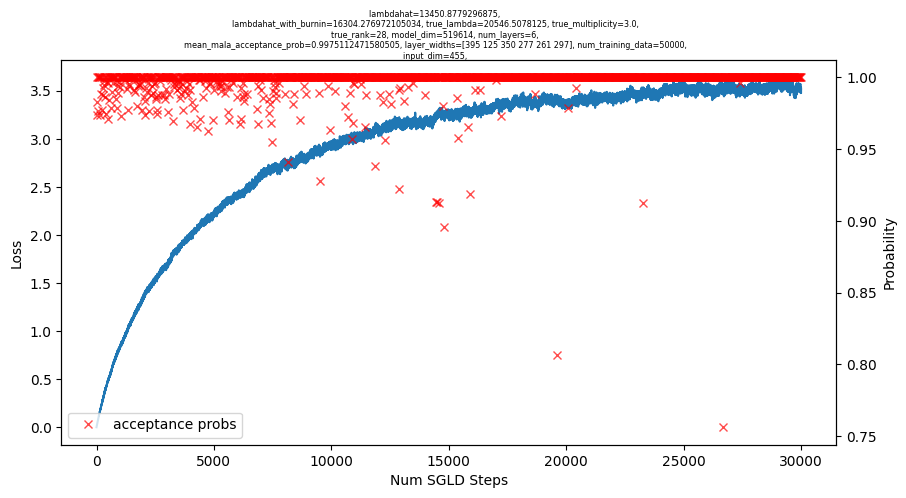

In [46]:
loss_trace = run.info['loss_trace']
init_loss = run.info['init_loss']
BURNIN_PROP = 0.9
nsteps = len(loss_trace)
burnin = int(nsteps * BURNIN_PROP)
n = run.config["num_training_data"]
run.info["lambdahat_with_burnin"] = (np.mean(loss_trace[burnin:]) - init_loss) * n / np.log(n)
run.info["num_layers"] = len(run.config["layer_widths"])
probs = np.array(run.info["mala_acceptance_probs"])
mean_prob = probs[:, 1].mean()
run.info["mean_mala_acceptance_prob"] = mean_prob

suptitle = ""
items = [
    "lambdahat", "lambdahat_with_burnin", "true_lambda", 
    "true_multiplicity", "true_rank", "model_dim", 
    "num_layers", "mean_mala_acceptance_prob", "layer_widths",
    "num_training_data", "input_dim"
]
for i, elem in enumerate(items):
    if elem in run.info:
        print(f"{elem:25s}: {run.info[elem]}")
        suptitle += f"{elem}={run.info[elem]}, "
    elif elem in run.config:
        print(f"{elem:25s}: {run.config[elem]}")
        suptitle += f"{elem}={run.config[elem]}, "
    else:
        print(f"{elem:25s}: NOT FOUND")
    
    if i % 3 == 0:
        suptitle += "\n"



fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(run.info["loss_trace"], label="loss trace")
ax.set_ylabel("Loss")
ax.set_xlabel("Num SGLD Steps")
# ax.legend()
ax = ax.twinx()
ax.plot(probs[:, 0], probs[:, 1], "rx", label="acceptance probs", alpha=0.7)

ax.set_ylabel("Probability")
ax.set_xlabel("Num SGLD Steps")
ax.legend();

fig.suptitle(suptitle, fontsize="xx-small");